In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [21]:
CATEGORIES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [22]:
# implement your own NNs
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding = 'same')
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding = 'same')
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 'same')
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding = 'same')
        
        
        self.dropout = nn.Dropout(p=0.25)
        
        self.fc1 = nn.Linear(3136, 512)
        
        self.fc2 = nn.Linear(512, 10)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # TODO: YOUR CODE HERE
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(F.max_pool2d(x, 2))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.dropout(F.max_pool2d(x, 2))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

    def name(self):
        return "MyNeuralNetwork"

In [23]:
def training(model, data_loader, optimizer, criterion, device):
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for batch_idx, (inputs, labels) in enumerate(data_loader):

        # zero the parameter gradients
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # backward
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if batch_idx % 50 == 0:
            print(f'Training Batch: {batch_idx:4} of {len(data_loader)}')

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print('-' * 10)
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc

In [24]:
def test(model, data_loader, criterion, device):
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    # do not compute gradients
    with torch.no_grad():

        for batch_idx, (inputs, labels) in enumerate(data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if batch_idx % 100 == 0:
                print(f'Test Batch: {batch_idx:4} of {len(data_loader)}')

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = running_corrects.double() / len(data_loader.dataset)

    print('-' * 10)
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc

In [41]:
def plot(train_history, test_history, metric, num_epochs):

    plt.title(f"Validation/Test {metric} vs. Number of Training Epochs")
    plt.xlabel(f"Training Epochs")
    plt.ylabel(f"Validation/Test {metric}")
    plt.plot(range(1, num_epochs + 1), train_history, label="Train")
    plt.plot(range(1, num_epochs + 1), test_history, label="Test")
    plt.ylim((0, 1.))
    plt.xticks(np.arange(1, num_epochs + 1, 1.0))
    plt.legend()
    plt.savefig(f"../output/{metric}.png")
    plt.show()

In [28]:
print(torch.cuda.is_available())

True


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
# set seed for reproducability
torch.manual_seed(0)

In [32]:
# Set hyperparameters
batch_size = 512
num_epochs = 10
learning_rate = 0.001
momentum = 0.9

In [33]:
# Create data loaders
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor()
])

In [34]:
# load train and test data
root = './data'
train_set = datasets.FashionMNIST(root=root,
                                  train=True,
                                  transform=transform,
                                  download=True)
test_set = datasets.FashionMNIST(root=root,
                                 train=False,
                                 transform=transform,
                                 download=True)

In [35]:
loader_params = {
    'batch_size': batch_size,
    'num_workers': 8  # increase this value to use multiprocess data loading
}

In [36]:
train_loader = DataLoader(dataset=train_set, shuffle=True, **loader_params)
test_loader = DataLoader(dataset=test_set, shuffle=False, **loader_params)

In [38]:
## model setup
model = MyNeuralNetwork().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

In [39]:
best_acc = 0.0
since = time.time()

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # train
    training_loss, training_acc = training(model, train_loader, optimizer,
                                           criterion, device)
    train_loss_history.append(training_loss)
    train_acc_history.append(training_acc)

    # test
    test_loss, test_acc = test(model, test_loader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

    # overall best model
    if test_acc > best_acc:
        best_acc = test_acc
        #  best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(
    f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s'
)
print(f'Best val Acc: {best_acc:4f}')

Epoch 0/9
----------
Training Batch:    0 of 118
Training Batch:   50 of 118
Training Batch:  100 of 118
----------
Training Loss: 2.3026 Acc: 0.1056

Test Batch:    0 of 20
----------
Test Loss: 2.3018 Acc: 0.1029

Epoch 1/9
----------
Training Batch:    0 of 118
Training Batch:   50 of 118
Training Batch:  100 of 118
----------
Training Loss: 2.3011 Acc: 0.1383

Test Batch:    0 of 20
----------
Test Loss: 2.2998 Acc: 0.1816

Epoch 2/9
----------
Training Batch:    0 of 118
Training Batch:   50 of 118
Training Batch:  100 of 118
----------
Training Loss: 2.2981 Acc: 0.1757

Test Batch:    0 of 20
----------
Test Loss: 2.2952 Acc: 0.2128

Epoch 3/9
----------
Training Batch:    0 of 118
Training Batch:   50 of 118
Training Batch:  100 of 118
----------
Training Loss: 2.2893 Acc: 0.1909

Test Batch:    0 of 20
----------
Test Loss: 2.2777 Acc: 0.2021

Epoch 4/9
----------
Training Batch:    0 of 118
Training Batch:   50 of 118
Training Batch:  100 of 118
----------
Training Loss: 2.211

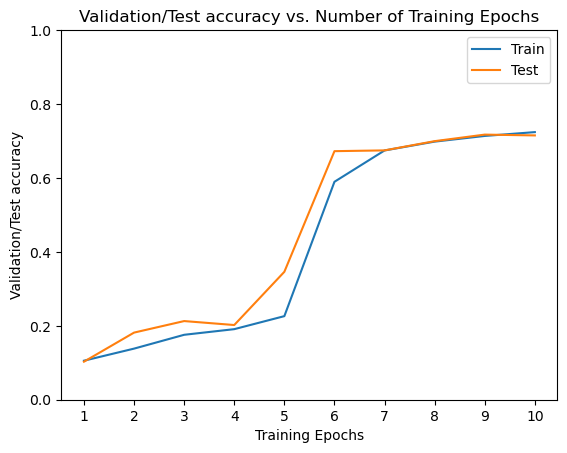

In [50]:
# plot loss and accuracy curves
plot(train_acc_history, test_acc_history, 'accuracy', num_epochs)

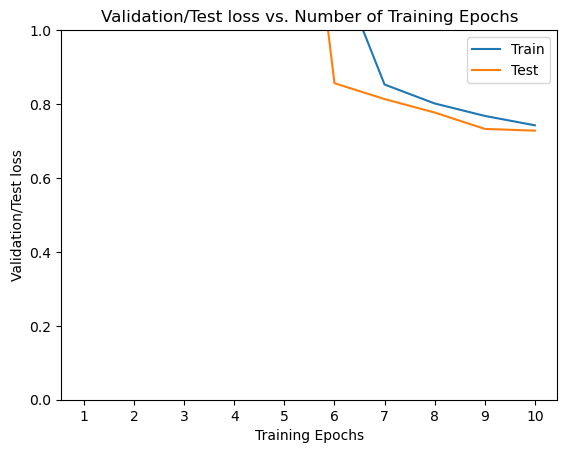

In [51]:
plot(train_loss_history, test_loss_history, 'loss', num_epochs)

In [52]:
# plot examples
example_data, _ = next(iter(test_loader))

type(example_data)

torch.Tensor

C:\Users\DELL\AppData\Local\Temp\ipykernel_11084\105879666.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_11084\105879666.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


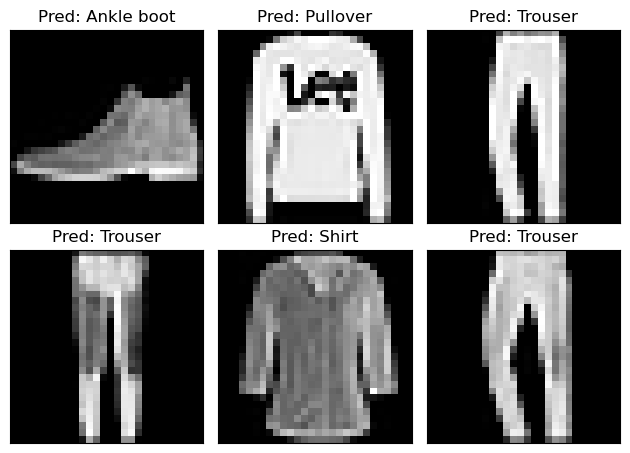

In [58]:
# plot examples
with torch.no_grad():
    # Move the model to the CPU
    model = model.to('cpu')
    
    # Move the input data to the CPU
    example_data = example_data.to('cpu')

    output = model(example_data)

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Pred: {}".format(CATEGORIES[output.data.max(
            1, keepdim=True)[1][i].item()]))
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.savefig("../output/examples.png")
    
    plt.show()